In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)
    
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [4]:
def rescale_plot(W=5, rectangle=False):
    if rectangle:
        plt.rcParams.update({
            'figure.figsize': (W, W/(6/3)),     # 4:3 aspect ratio
            'font.size' : 8,                   # Set font size to 11pt
            'axes.labelsize': 8,               # -> axis labels
            'legend.fontsize': 8,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })
    else:
        plt.rcParams.update({
            'figure.figsize': (W, W/(4/3)),     # 4:3 aspect ratio
            'font.size' : 8,                   # Set font size to 11pt
            'axes.labelsize': 8,               # -> axis labels
            'legend.fontsize': 8,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })

# Data

In [5]:
from AOE.gp_utils import Wasserstein_GP_mean, Wasserstein_GP
from AOE.gp_bandit_finance import gp_bandit_finance

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [6]:
all_rewards = pd.read_pickle('../data/Rewards/2021-10-21_rewards.pkl')
all_data    = pd.read_pickle('../data/Rewards/2021-10-21_rewards.pkl')
all_rewards = all_rewards[~all_rewards.index.duplicated()]

In [7]:
# all_rewards['imbalance_1'] = all_rewards['imbalance_1'].rolling(5).mean()
# all_rewards['MR'] = all_rewards['MR'].rolling(5).mean()
# all_rewards['TF'] = all_rewards['TF'].rolling(5).mean()

In [8]:
all_rewards  = all_rewards.dropna()

In [9]:
reward_imbalance = all_rewards['sellPrice_imbalance_1'] - all_rewards['twapPrice'] #lambda x: (x-1.333)**2
reward_trend     = all_rewards['sellPrice_TF'] - all_rewards['twapPrice']
reward_MR        = all_rewards['sellPrice_MR'] - all_rewards['twapPrice']

In [197]:
# pd.concat((reward_imbalance, all_rewards['imbalance_1']), axis=1).iloc[-1000:].set_index('imbalance_1').sort_index().plot()
# reward_MR        = reward_MR.dropna().rolling(3).mean().dropna()
# reward_imbalance = reward_imbalance.dropna().rolling(3).mean().dropna()
# reward_trend     = reward_trend.dropna().rolling(3).mean().dropna()

In [9]:
# waaaw.groupby('TF').mean()

In [10]:
models_TF = pd.concat((all_rewards.TF.round(1), reward_trend), axis=1)
models_MR = pd.concat((all_rewards.MR.round(1), reward_MR), axis=1)
models_IMB = pd.concat((all_rewards.imbalance_1.round(1), reward_imbalance), axis=1)

In [342]:
# all_rewards_

In [343]:
# plt.scatter(reward_imbalance.iloc[:30], all_rewards['imbalance_1'].iloc[:30])


# Trading simulation

In [11]:
strategies  = {'TF' :          {'name'             : 'TF',
                                'params'           : {'feature_name'     : 'TF'},
                                'contextual_params': {'feature_name'     : 'TF'}},
              'MR'  :          {'name'             : 'MR',
                                'params'           : {'feature_name'     : 'MR'},
                                'contextual_params': {'feature_name'     : 'MR'}},
              'imbalance_1' :          {'name'             : 'imbalance_1',
                                'params'           : {'feature_name'     : 'imbalance_1'},
                                'contextual_params': {'feature_name'     : 'imbalance_1'}}
              }

In [12]:
size_buffer   = 500
size_window   = 500
tick_size     = 0.01

likelihood    = gpytorch.likelihoods.GaussianLikelihood()

bandit_params = {'size_buffer': size_buffer, 
                 'size_window': size_window,
                 'threshold'  : 0.0005,
                 'lambda'     : 0.1 }

In [13]:
# models_/tick_size


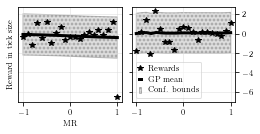

In [25]:
rescale_plot(W = 3.5, rectangle = True)

bandit1 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)
bandit2 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 2,
                           bandit_params=bandit_params)

best_strategy_bandit = 'imbalance_1'
distances            = []

models1_ = models_IMB.first('5min').groupby(best_strategy_bandit).mean().reset_index()
models2_ = models_IMB.first('10min').last('3min').groupby(best_strategy_bandit).mean().reset_index()

for i in range(0, len(models1_), 1):
    feature_values = models1_.iloc[i, :]
    reward         = models1_.iloc[i, 1]/tick_size
    bandit1.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

for i in range(0, len(models2_), 1):
    feature_values = models2_.iloc[i, :]
    reward         = models2_.iloc[i, 1]/tick_size
    bandit2.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

lv = -1
uv = 1

strat  = best_strategy_bandit
strats = bandit1.strategies.keys()

f, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True,
                           sharex=True, sharey=True)
gp1, gp2 = bandit1.strat_gp_dict[strat], bandit2.strat_gp_dict[strat]
ax = gp1.build_plot(ax, lv=lv, uv=uv, 
                   n_test=20, xlabel=None)
ax2 = gp2.build_plot(ax2, lv=lv, uv=uv, 
                   n_test=20, xlabel=None)

ax2.legend(['Rewards', 'GP mean', 'Conf. bounds'], 
      handlelength=0.3, framealpha=0.6, loc='best', ncol=1)
ax.set_ylabel('Avg. reward in tick size')
ax.set_xlabel('MR')
ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

# ax.set_ylim(-4, 4)
plt.show()

In [30]:
# models_MR.first('5min')

,MR,0
2021-10-21 09:30:01.031769,-0.3,0.014608
2021-10-21 09:30:02.012061,-0.3,-0.038665
2021-10-21 09:30:03.040047,-0.0,-0.042817
2021-10-21 09:30:03.753893,-0.4,0.003397
2021-10-21 09:30:05.089522,-0.7,-0.072055
...,...,...
2021-10-21 09:34:57.008796,-0.1,-0.021771
2021-10-21 09:34:58.402749,0.3,-0.035256
2021-10-21 09:34:59.095998,0.2,-0.024088
2021-10-21 09:35:00.007071,-0.4,0.017353


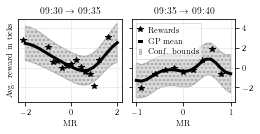

In [35]:
rescale_plot(W = 3.5, rectangle = True)

bandit1 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 3,
                           bandit_params=bandit_params)
bandit2 = gp_bandit_finance(strategies,
                           bandit_algo='UCB', 
                           training_iter = 3,
                           bandit_params=bandit_params)

best_strategy_bandit = 'MR'
distances            = []

models1_ = models_MR.first('5min').groupby(best_strategy_bandit).mean().reset_index()
models2_ = models_MR.first('10min').last('3min').groupby(best_strategy_bandit).mean().reset_index()

for i in range(0, len(models1_), 2):
    feature_values = models1_.iloc[i, :]
    reward         = models1_.iloc[i, 1]/tick_size
    bandit1.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

for i in range(0, len(models2_), 2):
    feature_values = models2_.iloc[i, :]
    reward         = models2_.iloc[i, 1]/tick_size
    bandit2.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

lv = -2
uv = 2
strat  = 'MR'
strats = bandit1.strategies.keys()

f, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True,
                            sharey=True)
gp1, gp2 = bandit1.strat_gp_dict[strat], bandit2.strat_gp_dict[strat]
ax = gp1.build_plot(ax, lv=lv, uv=uv, 
                   n_test=20, xlabel=None)

lv = -1
uv = 1
ax2 = gp2.build_plot(ax2, lv=lv, uv=uv, 
                   n_test=20, xlabel=None)

ax2.legend(['Rewards', 'GP mean', 'Conf. bounds'], 
      handlelength=0.3, framealpha=0.6, loc='best', ncol=1)
ax.set_ylabel('Avg. reward in ticks')
ax.set_xlabel('MR')
ax2.set_xlabel('MR')
ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

ax.set_title(r'09:30 $\rightarrow$ 09:35')
ax2.set_title(r'09:35 $\rightarrow$ 09:40')

# ax.set_ylim(-4, 4)
plt.savefig('GP1.pdf', bbox_inches='tight')
plt.show()

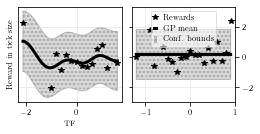

In [22]:
rescale_plot(W = 3.5, rectangle = True)

bandit1 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)
bandit2 = gp_bandit_finance(strategies,
                           bandit_algo='UCB', 
                           training_iter = 10,
                           bandit_params=bandit_params)

best_strategy_bandit = 'TF'
distances            = []

models1_ = models_TF.first('5min').groupby(best_strategy_bandit).mean().reset_index()
models2_ = models_TF.first('10min').last('5min').groupby(best_strategy_bandit).mean().reset_index()

for i in range(0, len(models1_), 2):
    feature_values = models1_.iloc[i, :]
    reward         = models1_.iloc[i, 1]/tick_size
    bandit1.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

for i in range(0, len(models2_), 1):
    feature_values = models2_.iloc[i, :]
    reward         = models2_.iloc[i, 1]/tick_size
    bandit2.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

lv = None
uv = None

strat  = best_strategy_bandit
strats = bandit1.strategies.keys()

f, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True,
                            sharey=True)
gp1, gp2 = bandit1.strat_gp_dict[strat], bandit2.strat_gp_dict[strat]
ax = gp1.build_plot(ax, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)
ax2 = gp2.build_plot(ax2, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)

ax2.legend(['Rewards', 'GP mean', 'Conf. bounds'], 
      handlelength=0.3, framealpha=0.6, loc='best', ncol=1)
ax.set_ylabel('Reward in tick size')
ax.set_xlabel('TF')
ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

# ax.set_ylim(-4, 4)
plt.show()

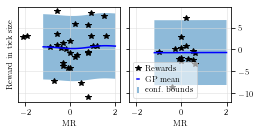

In [317]:
rescale_plot(W = 3.5, rectangle = True)

bandit1 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)
bandit2 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)

best_strategy_bandit = 'MR'
distances            = []

models_ = models_MR.dropna()
#.iloc[-500:].groupby(best_strategy_bandit
                                         # ).mean().reset_index()

for i in range(0, 30, 1):
    feature_values = models_.iloc[i, :]
    reward         = models_.iloc[i, 1]/tick_size
    bandit1.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)
for i in range(30, 60, 2):
    feature_values = models_.iloc[i, :]
    reward         = models_.iloc[i, 1]/tick_size
    bandit2.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)
    
rescale_plot(W = 3.5, rectangle = True)

lv = -1.2
uv = 2
strat  = 'MR'
strats = bandit.strategies.keys()

f, (ax, ax2) = plt.subplots(1, 2, 
                constrained_layout=True, 
                            sharex=True, sharey=True)
gp1, gp2 = bandit1.strat_gp_dict[strat], bandit2.strat_gp_dict[strat]
ax = gp1.build_plot(ax, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)
ax2 = gp2.build_plot(ax2, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)

ax2.legend(['Rewards', 'GP mean', 'conf. bounds'], 
      handlelength=0.3, framealpha=0.6, loc='best', ncol=1)
# ax.yaxis.tick_right()
ax.set_ylabel('Reward in tick size')
ax.set_xlabel('MR')
ax2.set_xlabel('MR')

ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

# ax.set_ylim(-4.5, 3)
plt.show()

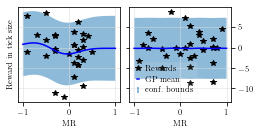

In [318]:
rescale_plot(W = 3.5, rectangle = True)

bandit1 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)
bandit2 = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 1,
                           bandit_params=bandit_params)

best_strategy_bandit = 'imbalance_1'
distances            = []

models_ = models_IMB.dropna()
#.iloc[-500:].groupby(best_strategy_bandit
                                         # ).mean().reset_index()

for i in range(0, 30, 1):
    feature_values = models_.iloc[i, :]
    reward         = models_.iloc[i, 1]/tick_size
    bandit1.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)
for i in range(30, 60, 1):
    feature_values = models_.iloc[i, :]
    reward         = models_.iloc[i, 1]/tick_size
    bandit2.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)
    
rescale_plot(W = 3.5, rectangle = True)

lv = -1
uv = 1
strat  = 'imbalance_1'
strats = bandit.strategies.keys()

f, (ax, ax2) = plt.subplots(1, 2, 
                constrained_layout=True, 
                            sharex=True, sharey=True)
gp1, gp2 = bandit1.strat_gp_dict[strat], bandit2.strat_gp_dict[strat]
ax = gp1.build_plot(ax, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)
ax2 = gp2.build_plot(ax2, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)

ax2.legend(['Rewards', 'GP mean', 'conf. bounds'], 
      handlelength=0.3, framealpha=0.1, loc='best', ncol=1)
# ax.yaxis.tick_right()
ax.set_ylabel('Reward in tick size')
ax.set_xlabel('MR')
ax2.set_xlabel('MR')

ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

# ax.set_ylim(-4.5, 3)
plt.show()

In [78]:
# models_IMB.iloc[40]
models_

,MR,0
0,-0.2,-0.004878
1,-0.1,0.002570
2,-0.0,-0.000602
3,0.1,-0.000571
4,0.2,-0.002192


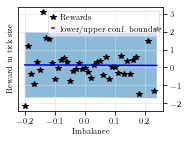

In [83]:
rescale_plot(W = 3, rectangle = True)

bandit = gp_bandit_finance(strategies, 
                           bandit_algo='UCB', 
                           training_iter = 0,
                           bandit_params=bandit_params)

best_strategy_bandit = 'MR'
distances            = []
models_ = models_MR.iloc[-2000:-1000].groupby(best_strategy_bandit
                                         ).mean().reset_index()

for i in range(0, len(models_)):
    feature_values = models_.iloc[i, :]
    reward         = models_.iloc[i, 1]/tick_size
    # print(feature_values[best_strategy_bandit], reward)
    bandit.update_data(feature_values, 
                       best_strategy_bandit, reward, 
                       retrain_hyperparameters = True)

rescale_plot(W = 2.5, rectangle = False)

strat  = 'MR'
lv = None
uv = None

strats = bandit.strategies.keys()
f, ax = plt.subplots(1, 1, constrained_layout=True)
gp = bandit.strat_gp_dict[strat]
ax = gp.build_plot(ax, lv=lv, uv=uv, 
                   n_test=100, xlabel=None)


ax.legend(['Rewards', 'lower/upper conf. bounds'], 
      handlelength=0.3, framealpha=0.6, loc='best', ncol=1)
ax.yaxis.tick_right()
ax.set_ylabel('Reward in tick size')
ax.set_xlabel('Imbalance')

# ax.set_xlim(-2, 3)
# ax.set_ylim(-0.8, 1.2)

plt.show()

In [77]:
models_MR.iloc[-2000]
# reward_MR

MR   -0.20000
0    -0.01022
Name: 2022-01-10 15:25:20.017164, dtype: float64

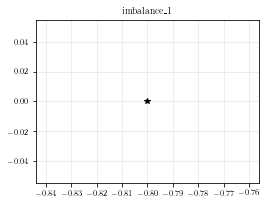

NanError: cholesky_cpu: 2 of 4 elements of the torch.Size([2, 2]) tensor are NaN.

In [54]:
%matplotlib inline
rescale_plot(W=3, rectangle=True)

## Plot both gp and value ucb at each time step with data point
## Try non stationarity
## Create synthetic random datapoints

best_strategy_bandit = 'imbalance_1'
reward_              = reward_imbalance
distances            = []
j                    = 0

bandit = gp_bandit_finance(strategies, bandit_algo = 'TS_WAS', 
                           likelihood              = likelihood, 
                           bandit_params           = bandit_params)

for i in range(0,30):
    j += 1
    
    feature_values = all_rewards.iloc[i]
    reward         = reward_.iloc[i]/tick_size
    bandit.update_data(feature_values.round(1), best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    if j > size_window:
        posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_confidence(best_strategy_bandit)
        
        train_x = bandit.strat_gp_dict[best_strategy_bandit].model.train_inputs[0]
        train_y = bandit.strat_gp_dict[best_strategy_bandit].model.train_targets
        
        train_x_1 = train_x[(-bandit.size_window//2):]
        train_y_1 = train_y[(-bandit.size_window//2):]
        train_x_2 = train_x[(-bandit.size_window):(- bandit.size_window//2)]
        train_y_2 = train_y[(-bandit.size_window):(- bandit.size_window//2)]
        
        posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window_covar(best_strategy_bandit)
        distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        distances.append(distance)
        
        test_x = torch.linspace(train_x.min().item(), train_x.max().item(), 100).double()
        f, ax  = plt.subplots(1, 1)
        
        ax.plot(train_x_1.numpy(), train_y_1.numpy(), 'k*', color='k')
        ax.plot(test_x.numpy(), posterior_mean_1.numpy(),   color='k')
        
        ax.plot(train_x_2.numpy(), train_y_2.numpy(), 'k*',  color='moccasin')
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(),  color='moccasin')
        
        ax.set_title(f"Wasserstein distance: distance {distance}")
        
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.4, color='k')
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.4, color='darkred')
        
        # ax.xaxis.set_major_formatter(myFmt)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("left")
        ax.grid(axis='both',  linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)        
        ax.set_ylabel('Reward in ticks')
        ax.set_xlabel('Imbalance')
        ax.legend(['GP1', '', 'GP2', ''], 
                   handlelength=0.2, framealpha=0.2, loc='best', ncol=2)

    if i%20==0:
        j = 0
        bandit.plot_strategies([best_strategy_bandit])
        bandit = gp_bandit_finance(strategies, bandit_algo = 'TS_WAS', 
                           likelihood              = likelihood, 
                           bandit_params           = bandit_params)
        
        # bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)